In [1]:
%load_ext lab_black

In [2]:
# ライブラリーのインポート
import math

import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.covariance

%matplotlib inline

import warnings

from sklearn.covariance import GraphicalLasso
from sklearn.preprocessing import StandardScaler

warnings.simplefilter("ignore")

In [3]:
df_temp = pd.read_csv("../data/water-treatment.csv", header=None, na_values="?")
df_temp.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,D-1/3/90,44101.0,1.5,7.8,NaN,407.0,166.0,66.3,4.5,2110,...,2000.0,NaN,58.8,95.5,NaN,70.0,NaN,79.4,87.3,99.6
1,D-2/3/90,39024.0,3.0,7.7,NaN,443.0,214.0,69.2,6.5,2660,...,2590.0,NaN,60.7,94.8,NaN,80.8,NaN,79.5,92.1,100.0
2,D-4/3/90,32229.0,5.0,7.6,NaN,528.0,186.0,69.9,3.4,1666,...,1888.0,NaN,58.2,95.6,NaN,52.9,NaN,75.8,88.7,98.5
3,D-5/3/90,35023.0,3.5,7.9,205.0,588.0,192.0,65.6,4.5,2430,...,1840.0,33.1,64.2,95.3,87.3,72.3,90.2,82.3,89.6,100.0
4,D-6/3/90,36924.0,1.5,8.0,242.0,496.0,176.0,64.8,4.0,2110,...,2120.0,NaN,62.7,95.6,NaN,71.0,92.1,78.2,87.5,99.5


In [4]:
# 欠損値データの削除
df_temp = df_temp.drop(df_temp.columns[0], axis=1)
df = df_temp.dropna()
df = df.reset_index(drop=True)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,34,35,36,37,38
0,35023.0,3.5,7.9,205.0,588.0,192.0,65.6,4.5,2430,7.8,...,1840.0,33.1,64.2,95.3,87.3,72.3,90.2,82.3,89.6,100.0
1,29156.0,2.5,7.7,206.0,451.0,194.0,69.1,4.5,1249,7.7,...,1338.0,46.1,43.6,92.5,85.6,58.2,92.2,73.8,90.2,99.4
2,39246.0,2.0,7.8,172.0,506.0,200.0,69.0,5.0,1865,7.8,...,1616.0,21.2,59.7,90.8,88.4,66.1,89.0,69.0,86.5,99.6
3,42393.0,0.7,7.9,189.0,478.0,230.0,67.0,5.5,1410,8.1,...,1575.0,0.6,45.8,92.0,11.6,25.7,19.6,36.0,43.0,36.4
4,40923.0,3.5,7.6,146.0,329.0,188.0,57.4,2.5,1300,7.6,...,1545.0,32.7,33.3,90.0,82.6,61.3,87.0,71.4,78.2,99.2


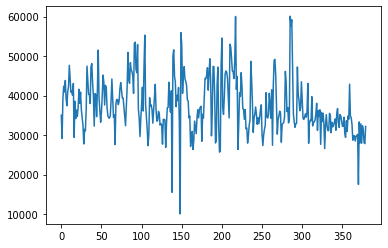

In [5]:
plt.figure(figsize=(6, 4))
plt.plot(df[1])

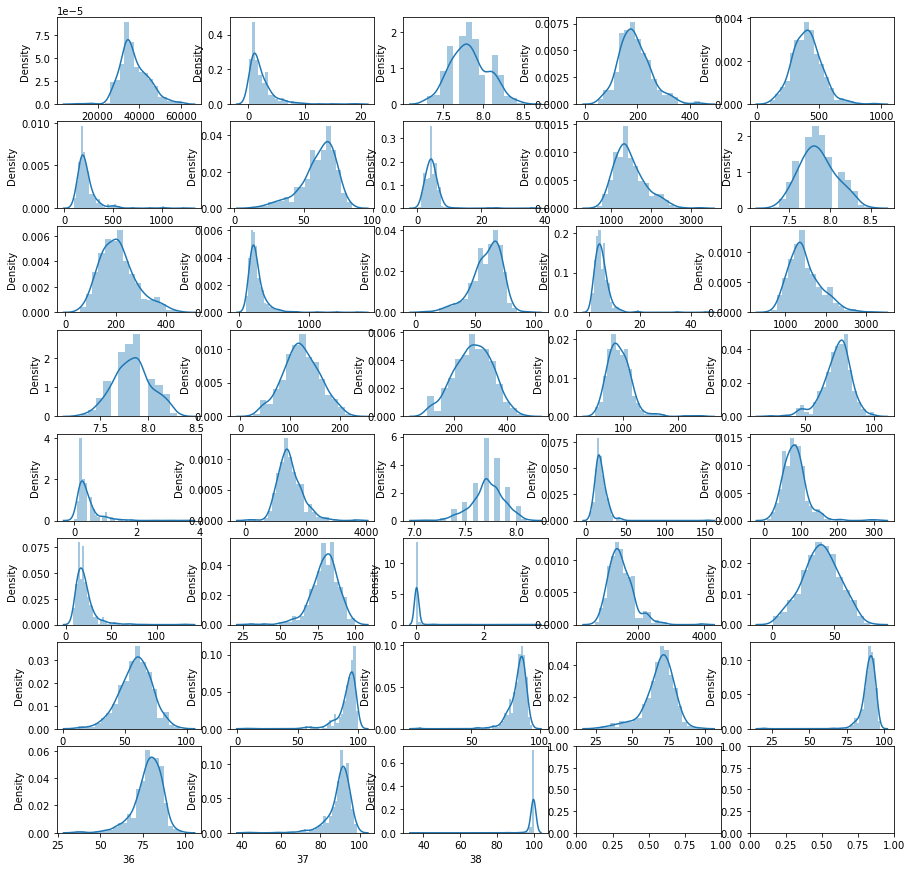

In [6]:
f, axes = plt.subplots(8, 5, figsize=(15, 15))
for i in range(len(df.columns)):
    sns.distplot(df[i + 1], ax=axes[int(i / 5)][int(i % 5)])

In [7]:
# 分割ポイント
split_point = 100
# 学習データ（train）と評価データ（test）に分割
df_train = df.iloc[
    : (split_point - 1),
]
df_test = df.iloc[
    split_point:,
]

# データを標準化
sc = StandardScaler()
sc.fit(df_train)
df_train_std = sc.transform(df_train)
df_test_std = sc.transform(df_test)

In [8]:
# 学習データ
model = sklearn.covariance.GraphicalLasso(alpha=0.1, mode="cd", verbose=False)
model.fit(df_train_std)

# 共分散
cov = np.cov(df_train_std, rowvar=0)
# 分散共分散行列
cov_ = model.covariance_
# 精度行列
pre_ = model.precision_

<AxesSubplot:title={'center':'Estimated precision'}>

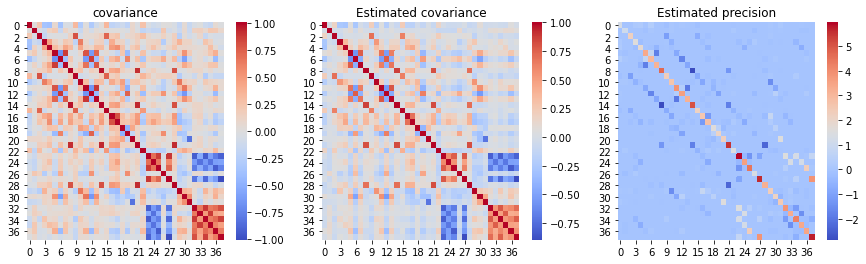

In [9]:
f, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].set_title("covariance")
axes[1].set_title("Estimated covariance")
axes[2].set_title("Estimated precision")

sns.heatmap(cov, ax=axes[0], cmap="coolwarm")
sns.heatmap(cov_, ax=axes[1], cmap="coolwarm")
sns.heatmap(pre_, ax=axes[2], cmap="coolwarm")

In [10]:
# KL距離の計算
def kl_divergence(GGM1, GGM2, S, n):
    """全ての評価指標を計算する

    Parameters
    ----------
    GGM1 : np.array
      学習データの精度行列（共分散行列の逆行列）
    GGM2 : np.array
      評価データの精度行列（共分散行列の逆行列）
    S     : np.array
      学習データの共分散行列
    n     : int
      カラム数

    Returns
    -------
    KL : list
      KL距離
    """
    KL = []
    for i in range(0, n):
        b = 1 / 2 * math.log(np.diag(GGM1)[i] / np.diag(GGM2)[i]) - 1 / 2 * (
            np.diag(GGM1 * S * GGM1)[i] / np.diag(GGM1)[i]
            - np.diag(GGM2 * S * GGM2)[i] / np.diag(GGM2)[i]
        )
        KL.append(b)

    return KL

In [11]:
# 評価データをグラフィカルラッソ
model_test = sklearn.covariance.GraphicalLasso(alpha=0.1, verbose=False)

# 　KL情報量の格納
d_ab = []

for i in range(0, (len(df_test_std) - len(df_train_std))):
    model_test.fit(df_test_std[0 + i : split_point + i])
    # 評価データの精度行列
    pre_test = model_test.precision_
    # KL情報量
    d_ab_temp = kl_divergence(pre_, pre_test, cov_, len(df.columns))
    d_ab.append(d_ab_temp)

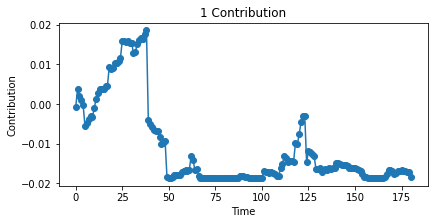

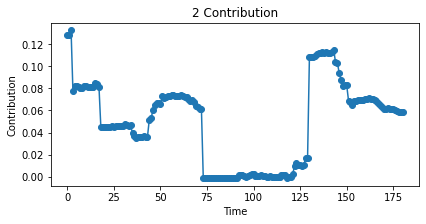

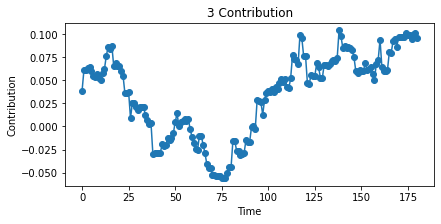

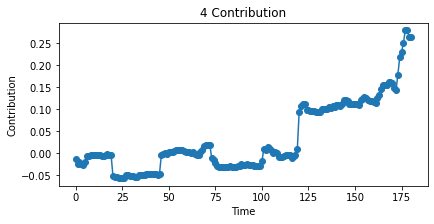

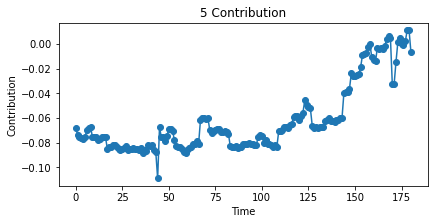

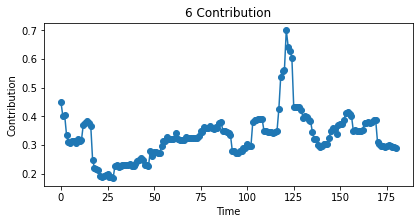

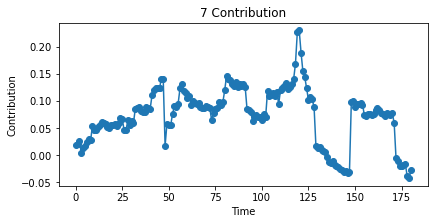

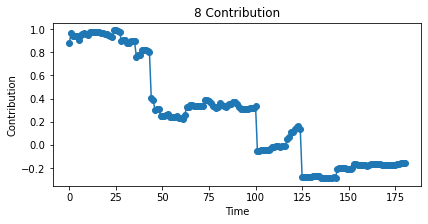

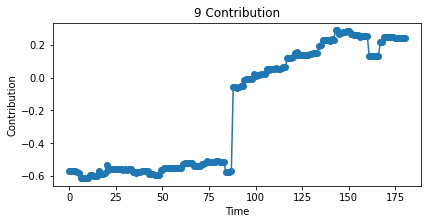

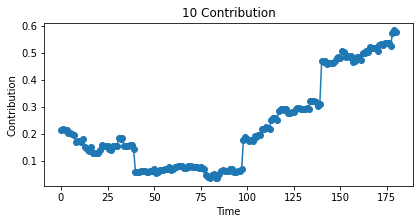

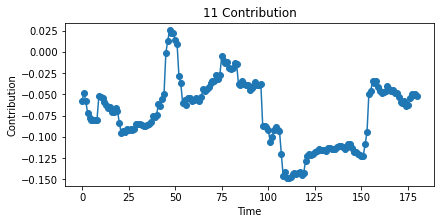

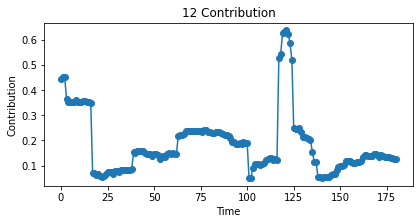

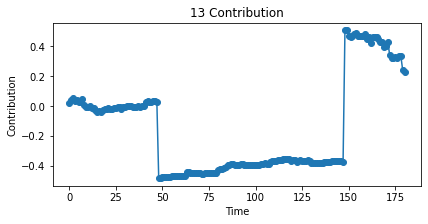

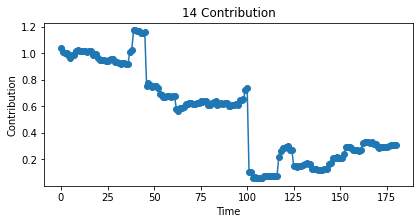

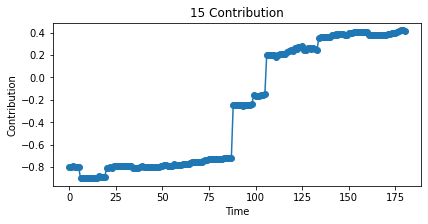

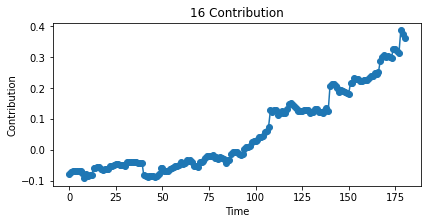

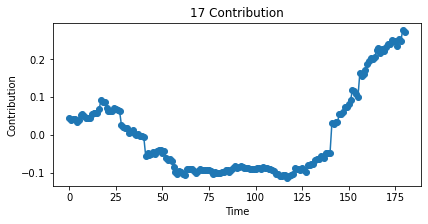

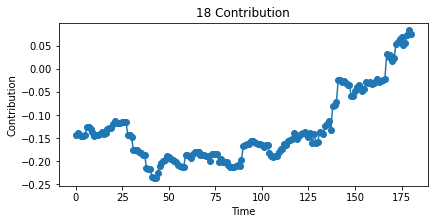

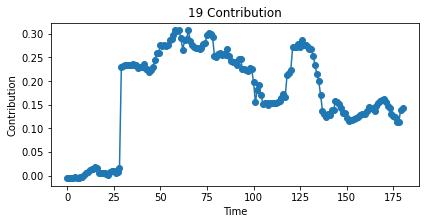

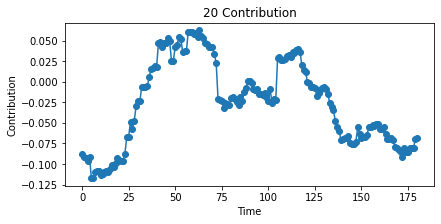

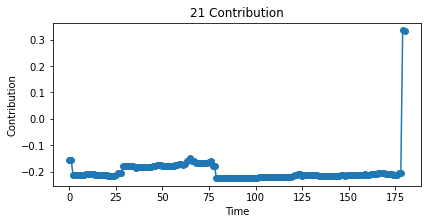

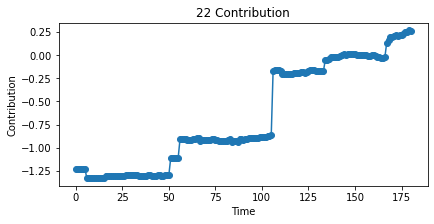

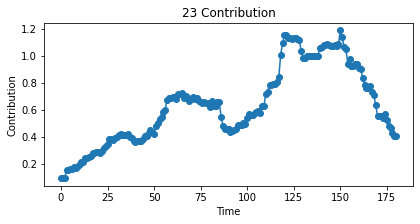

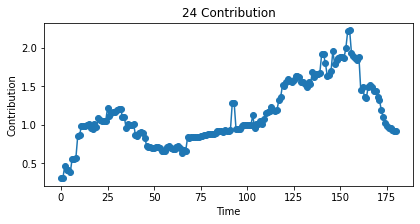

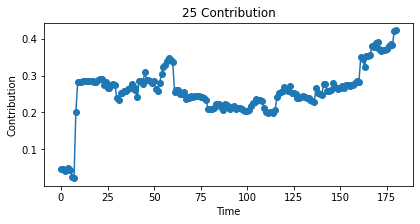

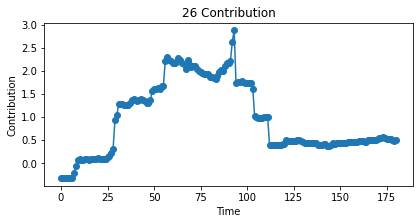

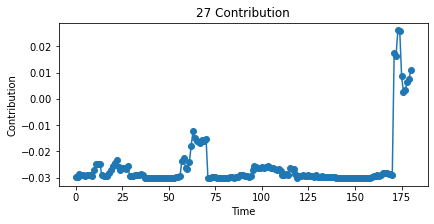

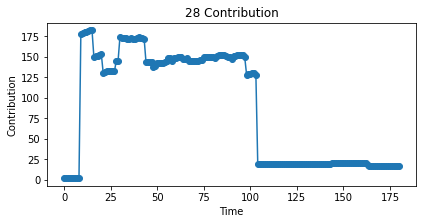

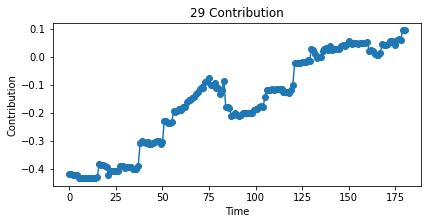

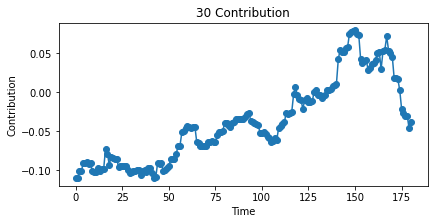

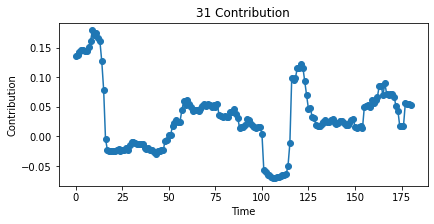

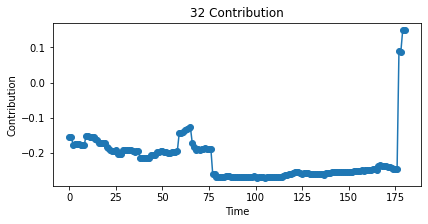

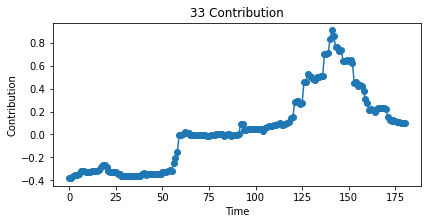

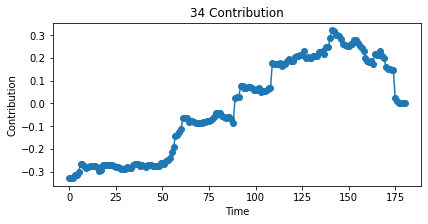

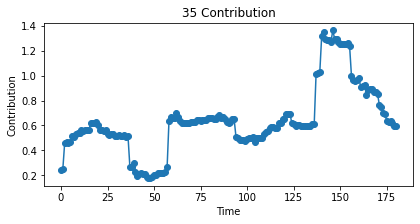

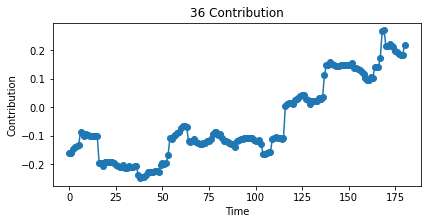

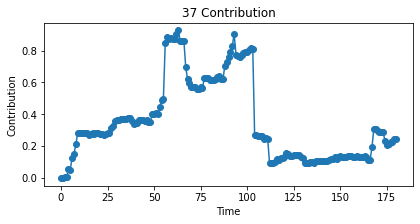

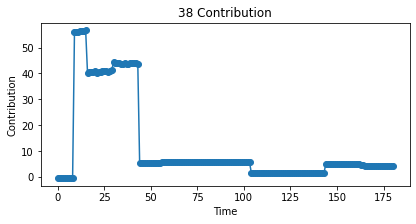

In [12]:
# 可視化
for i in range(len(df.columns)):
    plt.figure(figsize=(300, 3))
    plt.subplot(1, 38, i + 1)
    plt.title("%s Contribution" % (i + 1))
    plt.plot(np.array(d_ab)[:, i], marker="o")
    plt.xlabel("Time")
    plt.ylabel("Contribution")